In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/Colab\ Notebooks/scripts

/content/drive/MyDrive/Colab Notebooks/scripts


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os

In [4]:
from feature_selection import forwardFeatureSelection

from NonLinCFA import NonLinCFA

from aux_NonLinCFA import standardize,unfold_dataset,compute_r2,prepare_target,prepare_features,aggregate_unfolded_data,aggregate_unfolded_data_onlyTrain,FS_with_linearWrapper,compare_methods, compute_r2, aggregate_data_withoutUnfolding

In [5]:
cd ..

/content/drive/MyDrive/Colab Notebooks


In [6]:
def MTL_scores(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = LinearRegression()
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print(r2_score(targets_df_test[basin].values.ravel(), res))

# No winter test set

In [ ]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = "./csv/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',

                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv', window_size = 1)
    target_df_test_filtered = target_df_test.loc[(target_df_test['week'] > 9) & (target_df_test['week'] < 45)]
    no_winter_indices = target_df_test_filtered.index
    target_df_test_filtered.index = pd.RangeIndex(start=639, stop=639+len(target_df_test_filtered))

    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test_filtered.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std

In [ ]:
### CMI features
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

    test_temp.set_index(target_df_test.index, inplace=True)
    test_temp = test_temp.loc[no_winter_indices]
    test_temp.reset_index(inplace=True, drop= True)

    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [ ]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
0.2594821187765234
Emiliani2
0.23226229098797124
Garda_Mincio
0.1563314280463337


In [ ]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Adda
0.20473172226230285
Lambro_Olona
0.2948337484177459
Oglio_Iseo
0.24242927565644823
Ticino
0.26021173177146084


In [ ]:
basin = "Ticino"
lin_regr = LinearRegression()
# CMI best 5
best5_CMI_train_val = pd.concat([best5_CMI_fulldf_train.filter(like=basin), best5_CMI_fulldf_val.filter(like=basin)])
lin_regr.fit(best5_CMI_train_val, targets_df_trainVal[basin])
print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_train_val, targets_df_trainVal[basin]),3))
print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_fulldf_test.filter(like=basin), targets_df_test[basin]),3), "\n")

Train R2 linear regression CMI best 5:  0.18
Test R2 linear regression CMI best 5:  0.129 



# Winter only test set

In [ ]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = "./csv/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',

                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv', window_size = 1)
    target_df_test_filtered = target_df_test.loc[(target_df_test['week'] <= 9) | (target_df_test['week'] >= 45)]
    no_winter_indices = target_df_test_filtered.index
    target_df_test_filtered.index = pd.RangeIndex(start=639, stop=639+len(target_df_test_filtered))

    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test_filtered.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std

In [ ]:
### CMI features
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

    test_temp.set_index(target_df_test.index, inplace=True)
    test_temp = test_temp.loc[no_winter_indices]
    test_temp.reset_index(inplace=True, drop= True)

    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [ ]:
basin = "Ticino"
lin_regr = LinearRegression()
# CMI best 5
best5_CMI_train_val = pd.concat([best5_CMI_fulldf_train.filter(like=basin), best5_CMI_fulldf_val.filter(like=basin)])
lin_regr.fit(best5_CMI_train_val, targets_df_trainVal[basin])
print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_train_val, targets_df_trainVal[basin]),3))
print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_fulldf_test.filter(like=basin), targets_df_test[basin]),3), "\n")

Train R2 linear regression CMI best 5:  0.18
Test R2 linear regression CMI best 5:  0.164 



In [ ]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
0.3814450850327915
Emiliani2
0.3488093620029482
Garda_Mincio
0.3265624107007039


In [ ]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Adda
0.10782221692736738
Lambro_Olona
0.0676676634825647
Oglio_Iseo
0.09804228024670791
Ticino
0.08757101812274759


# Training without winter

In [ ]:
basins = ['Emiliani1', 'Emiliani2', 'Garda_Mincio']

path_target = "./csv/"
path_features = './features_allvalues/'
destination_folder = './NonLinCFA/temp_prec_internal_ordering/no_winter/'

for basin in basins:
  selected_colnames_CMI5 = []
  outputs = []
  print('####################' + basin + '####################')
  target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1, no_winter = True)
  eps = 0.1
  actual_path = path_features+basin+'_aggreg.csv'
  output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
                                                                       no_winter=True)
  outputs.append(output)

  res = {
            "delta" : [],
            "numSelected" : [],
            "selectedFeatures" : []
        }

  res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)

  selectedFeatures='selectedFeatures'
  print(f'\n{res[selectedFeatures]}\n')
  selected_colnames_CMI = aggregate_trainVal.columns[res['selectedFeatures']]

  print('\nFull model and selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames_CMI)

  print('\nFull model and best 5 selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames_CMI[0:5])

  selected_colnames_CMI5.append(aggregate_trainVal.loc[:,selected_colnames_CMI[0:5]].columns.values)

  train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test.csv'

  X_train_CMI5 = aggregate_trainVal.loc[:len(target_df_train)-1,selected_colnames_CMI[0:5]]
  X_validation_CMI5 = aggregate_trainVal.loc[len(target_df_train):,selected_colnames_CMI[0:5]]
  X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
  X_test_CMI5 = aggregate_test.loc[:,selected_colnames_CMI[0:5]]

  X_train_CMI5.to_csv(train_string, index=False)
  X_validation_CMI5.to_csv(val_string, index=False)
  X_test_CMI5.to_csv(test_string, index=False)

####################Emiliani1####################
Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 3

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 8

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 5

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 3

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 3

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 2

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 3

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 9

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 15

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 12

Number of features

In [ ]:
### targets
basins = ['Emiliani1','Emiliani2','Garda_Mincio']
path_targets = "./csv/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',

                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv', window_size = 1)
    target_df_test_filtered = target_df_test.loc[(target_df_test['week'] > 9) & (target_df_test['week'] < 45)]
    target_df_train_filtered = target_df_train.loc[(target_df_train['week'] > 9) & (target_df_train['week'] < 45)]
    target_df_val_filtered = target_df_val.loc[(target_df_val['week'] > 9) & (target_df_val['week'] < 45)]

    no_winter_indices_test = target_df_test_filtered.index
    no_winter_indices_train = target_df_train_filtered.index
    no_winter_indices_val = target_df_val_filtered.index

    target_df_train_filtered.reset_index(inplace = True, drop = True)
    target_df_val_filtered.index = pd.RangeIndex(start=len(target_df_train_filtered),
                                                 stop=len(target_df_train_filtered)+len(target_df_val_filtered))
    train_val_len = len(target_df_train_filtered)+len(target_df_val_filtered)
    target_df_test_filtered.index = pd.RangeIndex(start=train_val_len, stop=train_val_len+len(target_df_test_filtered))

    targets_df_train[basin] = target_df_train_filtered.mean_std
    targets_df_val[basin] = target_df_val_filtered.mean_std
    targets_df_test[basin] = target_df_test_filtered.mean_std
    targets_df_trainVal[basin] = pd.concat([target_df_train_filtered, target_df_val_filtered]).mean_std

In [ ]:
### CMI features
basins = ['Emiliani1','Emiliani2','Garda_Mincio']
path_features = './NonLinCFA/temp_prec_internal_ordering/no_winter/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

    #train_temp.set_index(target_df_train.index, inplace=True)
    #val_temp.set_index(target_df_val.index, inplace=True)
    #test_temp.set_index(target_df_test.index, inplace=True)

    #train_temp = train_temp.loc[no_winter_indices_train]
    #val_temp = val_temp.loc[no_winter_indices_val]
    #test_temp = test_temp.loc[no_winter_indices_test]

    #train_temp.reset_index(inplace=True, drop= True)
    #val_temp.reset_index(inplace=True, drop= True)
    #test_temp.reset_index(inplace=True, drop= True)

    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [ ]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
0.12533294243592297
Emiliani2
-0.0031236356925790076
Garda_Mincio
0.06125200515917395


In [ ]:
basin = "Garda_Mincio"
lin_regr = LinearRegression()
# CMI best 5
best5_CMI_train_val = pd.concat([best5_CMI_fulldf_train.filter(like=basin), best5_CMI_fulldf_val.filter(like=basin)])
lin_regr.fit(best5_CMI_train_val, targets_df_trainVal[basin])
print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_train_val, targets_df_trainVal[basin]),3))
print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_fulldf_test.filter(like=basin), targets_df_test[basin]),3), "\n")

Train R2 linear regression CMI best 5:  0.29
Test R2 linear regression CMI best 5:  0.231 



## Plots

In [ ]:
path_target = "./csv/"
basin = 'Emiliani1'

target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1, no_winter = True)

In [ ]:
target_df_test

,date,mean,median,year,week,mean_std
427,2015-03-09,0.428019,0.43,2015,11,-0.223568
428,2015-03-17,0.389292,0.39,2015,12,-0.482835
429,2015-03-25,0.534943,0.54,2015,13,0.492254
430,2015-04-02,0.565900,0.57,2015,14,0.699505
431,2015-04-10,0.531773,0.53,2015,15,0.471034
...,...,...,...,...,...,...
576,2019-09-28,0.503170,0.51,2019,39,0.279549
577,2019-10-06,0.439894,0.45,2019,40,-0.144068
578,2019-10-14,0.602455,0.63,2019,42,0.944229
579,2019-10-22,0.471975,0.49,2019,43,0.070703


Intercept of train+val signal:  -0.23081107802221013  Coef:  0.0019397482099418291


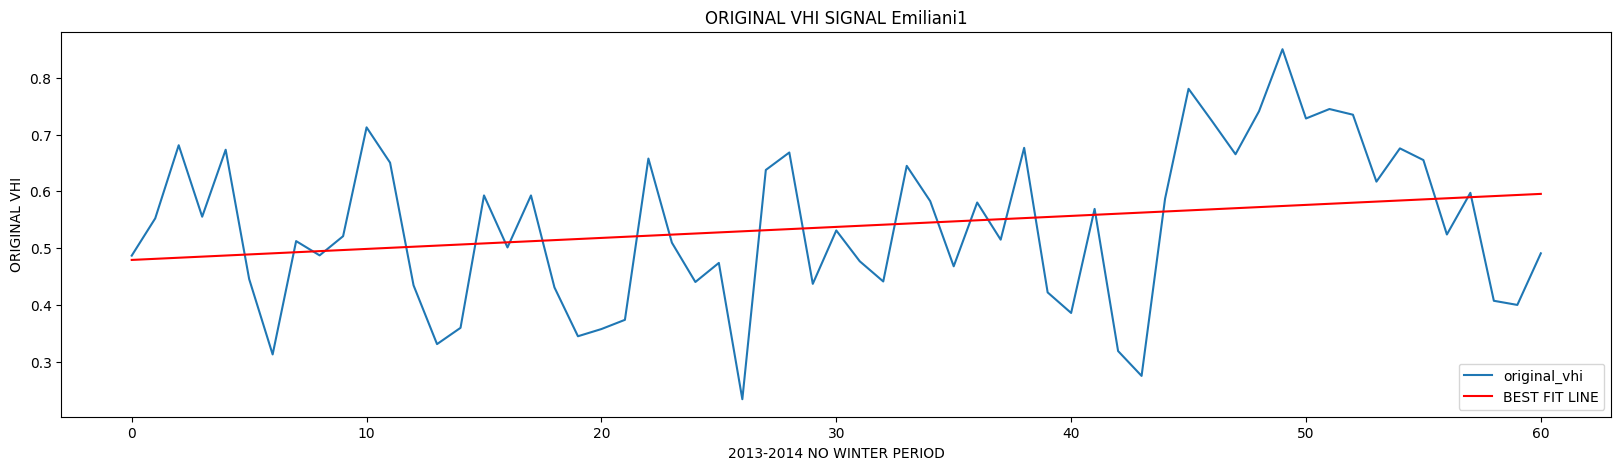

In [ ]:
target = target_df_trainVal.loc[(target_df_trainVal['year'] == 2013) | (target_df_trainVal['year'] == 2014)]['mean'].values
X = target_df_trainVal.loc[(target_df_trainVal['year'] == 2013) | (target_df_trainVal['year'] == 2014)].index.values
X = X.reshape(X.shape[0], 1)
regression = LinearRegression()
regression.fit(X, target)

best_fit = regression.intercept_ + regression.coef_[0] * X

plt.plot(target, label = "original_vhi")
plt.plot(best_fit, label ="BEST FIT LINE", color='red')
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel('2013-2014 NO WINTER PERIOD')
plt.ylabel('ORIGINAL VHI')
plt.title("ORIGINAL VHI SIGNAL " + basin)
plt.legend(loc="lower right")

print("Intercept of train+val signal: ", regression.intercept_, " Coef: ", regression.coef_[0])

Intercept of train+val signal:  0.278122554570774  Coef:  0.0003987016879454052


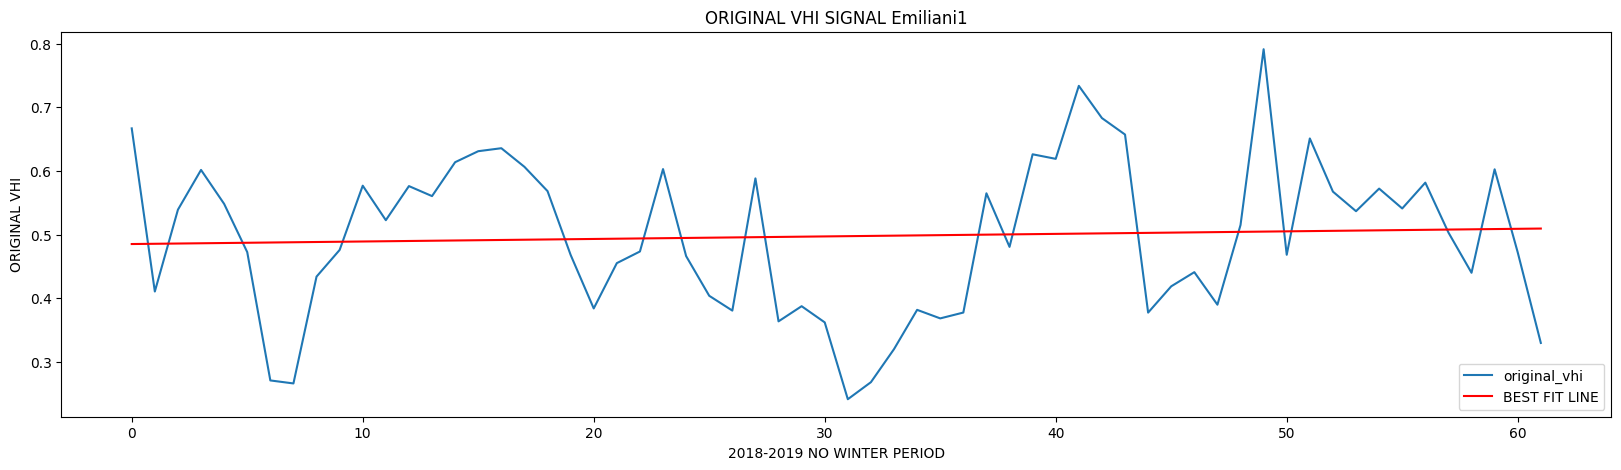

In [ ]:
target = target_df_test.loc[(target_df_test['year'] == 2018) | (target_df_test['year'] == 2019)]['mean'].values
X = target_df_test.loc[(target_df_test['year'] == 2018) | (target_df_test['year'] == 2019)].index.values
X = X.reshape(X.shape[0], 1)
regression = LinearRegression()
regression.fit(X, target)

best_fit = regression.intercept_ + regression.coef_[0] * X

plt.plot(target, label = "original_vhi")
plt.plot(best_fit, label ="BEST FIT LINE", color='red')
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel('2018-2019 NO WINTER PERIOD')
plt.ylabel('ORIGINAL VHI')
plt.title("ORIGINAL VHI SIGNAL " + basin)
plt.legend(loc="lower right")

print("Intercept of train+val signal: ", regression.intercept_, " Coef: ", regression.coef_[0])

Intercept of train+val signal:  0.46354391117610366  Coef:  1.82669058922248e-05


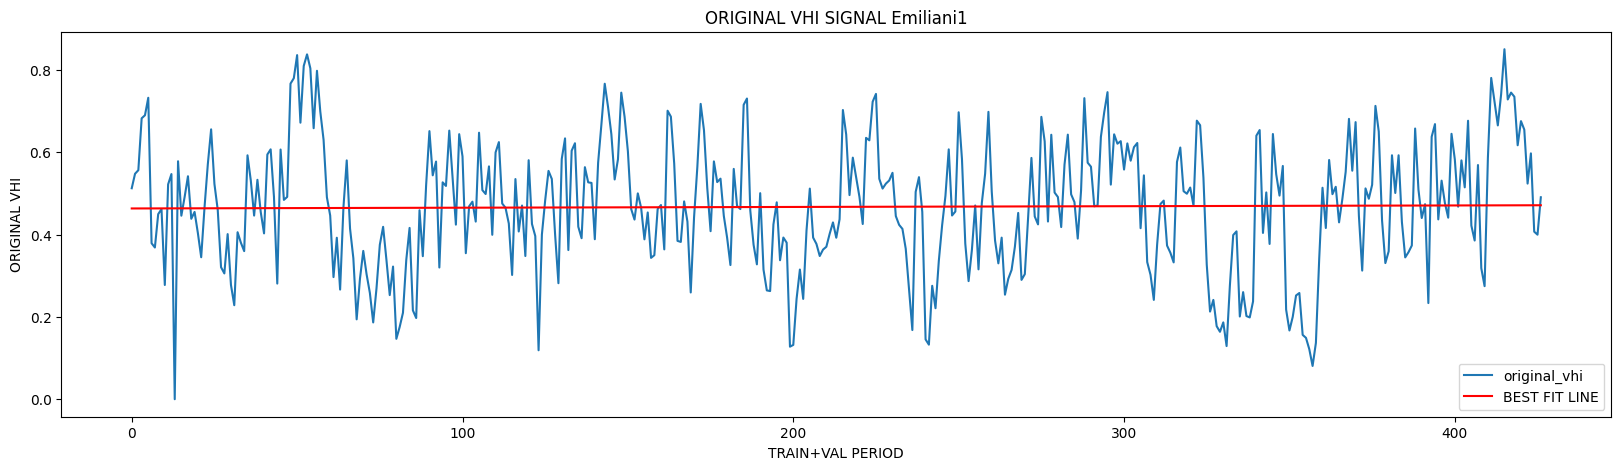

In [ ]:
target = target_df_trainVal['mean'].values
X = target_df_trainVal.index.values
X = X.reshape(X.shape[0], 1)
regression = LinearRegression()
regression.fit(X, target)

best_fit = regression.intercept_ + regression.coef_[0] * X

plt.plot(target, label = "original_vhi")
plt.plot(best_fit, label ="BEST FIT LINE", color='red')
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel('TRAIN+VAL PERIOD')
plt.ylabel('ORIGINAL VHI')
plt.title("ORIGINAL VHI SIGNAL " + basin)
plt.legend(loc="lower right")

print("Intercept of train+val signal: ", regression.intercept_, " Coef: ", regression.coef_[0])

Intercept of test signal:  0.47698946371150924  Coef:  1.3954504809548439e-05


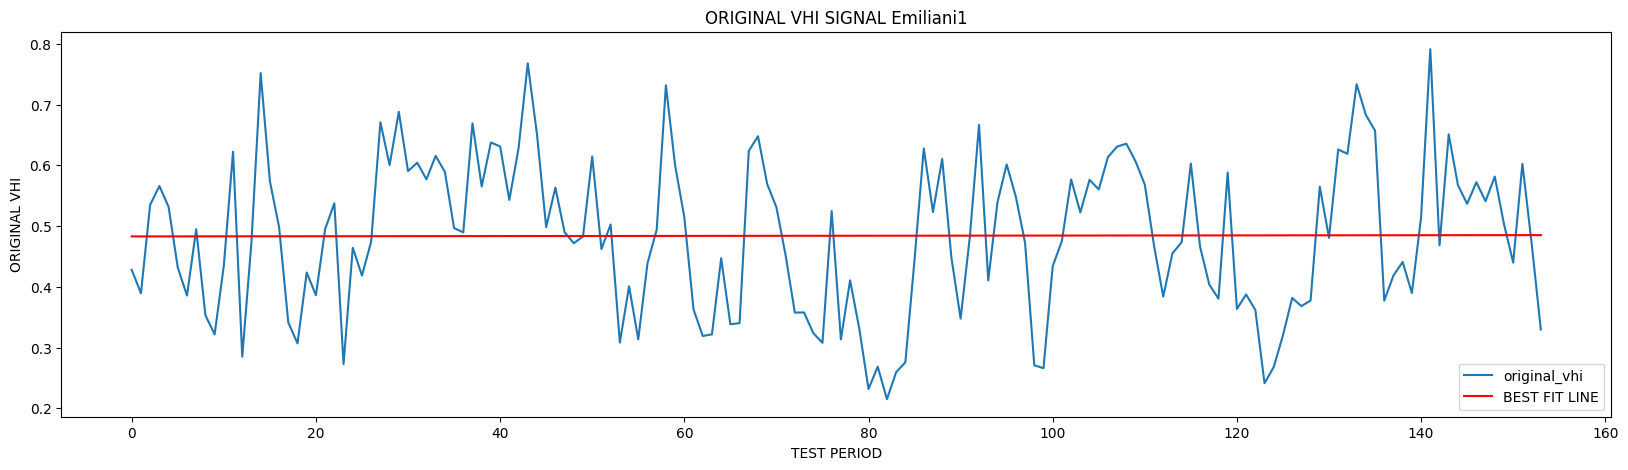

In [ ]:
target = target_df_test['mean'].values
X = target_df_test.index.values
X = X.reshape(X.shape[0], 1)
regression = LinearRegression()
regression.fit(X, target)

best_fit = regression.intercept_ + regression.coef_[0] * X

plt.plot(target, label = "original_vhi")
plt.plot(best_fit, label ="BEST FIT LINE", color='red')
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel('TEST PERIOD')
plt.ylabel('ORIGINAL VHI')
plt.title("ORIGINAL VHI SIGNAL " + basin)
plt.legend(loc="lower right")

print("Intercept of test signal: ", regression.intercept_, " Coef: ", regression.coef_[0])

## Test years anaysis

In [ ]:
best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()

In [ ]:
basin = 'Garda_Mincio'
path_features = './NonLinCFA/temp_prec_internal_ordering/no_winter/'
path_target = "./csv/"
target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1, no_winter = True)

train_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
val_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
test_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

In [ ]:
dfs_per_year = []
target_df_test.reset_index(inplace=True, drop=True)
for year in target_df_test['year'].unique():
    df_per_year = target_df_test[target_df_test['year'] == year]
    dfs_per_year.append(df_per_year)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
for df_per_year in dfs_per_year:
    year = df_per_year.year.values[0]
    lin_regr = LinearRegression()
    train_val_df = pd.concat([train_df, val_df])
    lin_regr.fit(train_val_df, target_df_trainVal.mean_std)
    print("Test R2 linear regression for year ", year, ": ",
          round(lin_regr.score(pd.merge(test_df, df_per_year.mean_std, left_index=True, right_index=True)[test_df.columns], df_per_year.mean_std),3), "\n")

Test R2 linear regression for year  2015 :  0.235 

Test R2 linear regression for year  2016 :  0.375 

Test R2 linear regression for year  2017 :  0.251 

Test R2 linear regression for year  2018 :  0.027 

Test R2 linear regression for year  2019 :  -0.166 



Intercept of train+val signal:  0.4968275457258065  Coef:  -0.0014841965524193556


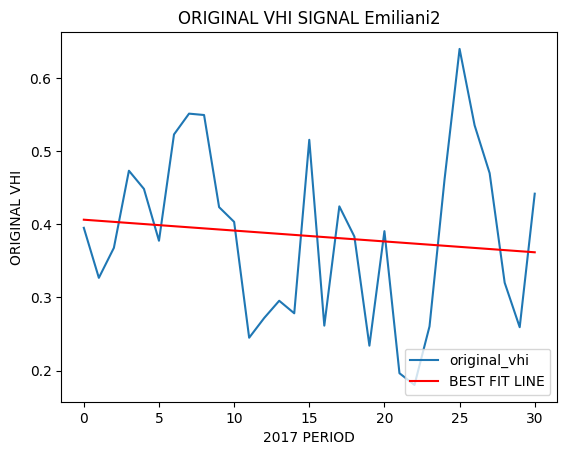

In [ ]:
target = dfs_per_year[2]['mean'].values
X = dfs_per_year[2].index.values
X = X.reshape(X.shape[0], 1)
regression = LinearRegression()
regression.fit(X, target)

best_fit = regression.intercept_ + regression.coef_[0] * X

plt.plot(target, label = "original_vhi")
plt.plot(best_fit, label ="BEST FIT LINE", color='red')
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel('2017 PERIOD')
plt.ylabel('ORIGINAL VHI')
plt.title("ORIGINAL VHI SIGNAL " + basin)
plt.legend(loc="lower right")

print("Intercept of train+val signal: ", regression.intercept_, " Coef: ", regression.coef_[0])

Intercept of train+val signal:  -0.11365151686290287  Coef:  0.004450903221774191


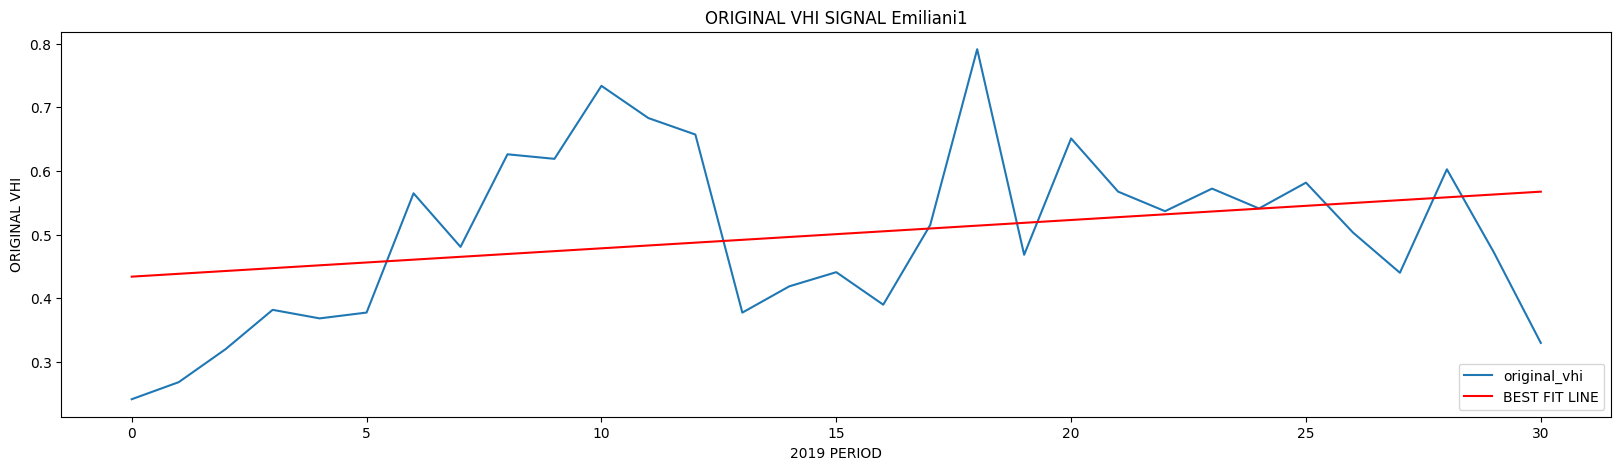

In [ ]:
target = dfs_per_year[4]['mean'].values
X = dfs_per_year[4].index.values
X = X.reshape(X.shape[0], 1)
regression = LinearRegression()
regression.fit(X, target)

best_fit = regression.intercept_ + regression.coef_[0] * X

plt.plot(target, label = "original_vhi")
plt.plot(best_fit, label ="BEST FIT LINE", color='red')
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel('2019 PERIOD')
plt.ylabel('ORIGINAL VHI')
plt.title("ORIGINAL VHI SIGNAL " + basin)
plt.legend(loc="lower right")

print("Intercept of train+val signal: ", regression.intercept_, " Coef: ", regression.coef_[0])

# Cross-valid no winter

In [7]:
best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()

In [8]:
basin = 'Emiliani2'
path_features = './NonLinCFA/temp_prec_internal_ordering/no_winter/'
path_target = "./csv/"
target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1, no_winter = True)

train_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
val_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
test_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

dfs_per_year = []
target_df_test.reset_index(inplace=True, drop=True)
for year in target_df_test['year'].unique():
    df_per_year = target_df_test[target_df_test['year'] == year]
    dfs_per_year.append(df_per_year)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
## 2018, 2019 from test set to training set, 2013, 2014 from training set to test set
worst_years = [dfs_per_year[i] for i in [3, 4]]
worst_years_df = pd.concat([worst_years[0], worst_years[1]])

# I add to training set the 2 worst years of test set: 2018, 2019
CMIbest5_worst_years = pd.merge(test_df, worst_years_df.mean_std, left_index=True, right_index=True)[test_df.columns]
new_training_df = pd.concat([train_val_df.iloc[:-62,:], CMIbest5_worst_years], ignore_index=True)

# I add to test set the last 2 years of old training set
test_df_without_worst_years = test_df[~test_df.index.isin(worst_years_df.index)]
test_df_without_worst_years.reset_index(inplace= True, drop= True)

new_test_df = pd.concat([test_df_without_worst_years, train_val_df.iloc[-62:,:]])
new_test_df.reset_index(inplace=True, drop=True)

new_target_train = pd.concat([target_df_trainVal.iloc[:-62,:], worst_years_df], ignore_index=True)

new_target_test = pd.concat([target_df_test[~target_df_test.index.isin(worst_years_df.index)],
                             target_df_trainVal.iloc[-62:,:]], ignore_index=True)

In [9]:
## 2018, 2019 removed, 2013, 2014 from training set to test set
worst_years = [dfs_per_year[i] for i in [3, 4]]
worst_years_df = pd.concat([worst_years[0], worst_years[1]])

# I add to training set the 2 worst years of test set: 2018, 2019
CMIbest5_worst_years = pd.merge(test_df, worst_years_df.mean_std, left_index=True, right_index=True)[test_df.columns]
train_val_df = pd.concat([train_df, val_df])
new_training_df = train_val_df.iloc[:-62,:]

# I add to test set the last 2 years of old training set
test_df_without_worst_years = test_df[~test_df.index.isin(worst_years_df.index)]
test_df_without_worst_years.reset_index(inplace= True, drop= True)

new_test_df = pd.concat([test_df_without_worst_years, train_val_df.iloc[-62:,:]])
new_test_df.reset_index(inplace=True, drop=True)

new_target_train =target_df_trainVal.iloc[:-62,:]

new_target_test = pd.concat([target_df_test[~target_df_test.index.isin(worst_years_df.index)],
                             target_df_trainVal.iloc[-62:,:]], ignore_index=True)

In [10]:
len(new_target_train)

365

In [ ]:
best5_CMI_fulldf_train[basin+'_'+new_test_df.columns.values] = new_training_df.iloc[:-153,:]
best5_CMI_fulldf_val[basin+'_'+new_test_df.columns.values] = new_training_df.iloc[-153:,:]
best5_CMI_fulldf_test[basin+'_'+new_test_df.columns.values] = new_test_df

targets_df_test[basin] = new_target_test.mean_std
targets_df_train[basin] = new_target_train.iloc[:-153,:].mean_std
targets_df_val[basin] = new_target_train.iloc[-153:,:].mean_std

In [ ]:
lin_regr = LinearRegression()

lin_regr.fit(new_training_df, new_target_train.mean_std)
print("Train R2 linear regression : ", round(lin_regr.score(new_training_df, new_target_train.mean_std),3))
print("Test R2 linear regression : ", round(lin_regr.score(new_test_df, new_target_test.mean_std),3))

Train R2 linear regression :  0.445
Test R2 linear regression :  0.225


In [ ]:
best5_CMI_fulldf_val.reset_index(inplace = True, drop = True)
targets_df_test.index = pd.RangeIndex(start=targets_df_val.index[-1] + 1,
                                      stop=targets_df_val.index[-1] + 1 + len(targets_df_test))

In [ ]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
0.2878995687250321
Emiliani2
0.2979958653067647
Garda_Mincio
0.31498219683571804


# Cross-valid with winter

In [ ]:
best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()

In [ ]:
basin = 'Garda_Mincio'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'
path_target = "./csv/"
target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1, no_winter = False)

train_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
val_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
test_df = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

In [ ]:
dfs_per_year = []
target_df_test.reset_index(inplace=True, drop=True)
for year in target_df_test['year'].unique():
    df_per_year = target_df_test[target_df_test['year'] == year]
    dfs_per_year.append(df_per_year)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
print("R2 test scores with winter: \n")
for df_per_year in dfs_per_year:
    year = df_per_year.year.values[0]
    lin_regr = LinearRegression()
    train_val_df = pd.concat([train_df, val_df])
    lin_regr.fit(train_val_df, target_df_trainVal.mean_std)
    print("Test R2 linear regression for year ", year, ": ",
          round(lin_regr.score(pd.merge(test_df, df_per_year.mean_std, left_index=True, right_index=True)[test_df.columns], df_per_year.mean_std),3), "\n")

R2 test scores with winter: 

Test R2 linear regression for year  2015 :  0.201 

Test R2 linear regression for year  2016 :  0.113 

Test R2 linear regression for year  2017 :  0.039 

Test R2 linear regression for year  2018 :  0.18 

Test R2 linear regression for year  2019 :  -0.076 



In [ ]:
worst_years = [dfs_per_year[i] for i in [3, 4]]
worst_years_df = pd.concat([worst_years[0], worst_years[1]])

# I add to training set the 2 worst years of test set: 2015, 2019
CMIbest5_worst_years = pd.merge(test_df, worst_years_df.mean_std, left_index=True, right_index=True)[test_df.columns]
new_training_df = pd.concat([train_val_df.iloc[:-62,:], CMIbest5_worst_years], ignore_index=True)

# I add to test set the last 2 years of old training set
test_df_without_worst_years = test_df[~test_df.index.isin(worst_years_df.index)]
test_df_without_worst_years.reset_index(inplace= True, drop= True)

new_test_df = pd.concat([test_df_without_worst_years, train_val_df.iloc[-62:,:]])
new_test_df.reset_index(inplace=True, drop=True)

new_target_train = pd.concat([target_df_trainVal.iloc[:-62,:], worst_years_df], ignore_index=True)

new_target_test = pd.concat([target_df_test[~target_df_test.index.isin(worst_years_df.index)],
                             target_df_trainVal.iloc[-62:,:]], ignore_index=True)

In [ ]:
best5_CMI_fulldf_train[basin+'_'+new_test_df.columns.values] = new_training_df.iloc[:-len(target_df_val),:]
best5_CMI_fulldf_val[basin+'_'+new_test_df.columns.values] = new_training_df.iloc[-len(target_df_val):,:]
best5_CMI_fulldf_test[basin+'_'+new_test_df.columns.values] = new_test_df

In [ ]:
targets_df_test[basin] = new_target_test.mean_std
targets_df_train[basin] = new_target_train.iloc[:-len(target_df_val),:].mean_std
targets_df_val[basin] = new_target_train.iloc[-len(target_df_val):,:].mean_std

In [ ]:
lin_regr = LinearRegression()

lin_regr.fit(new_training_df, new_target_train.mean_std)
print("Train R2 linear regression : ", round(lin_regr.score(new_training_df, new_target_train.mean_std),3))
print("Test R2 linear regression : ", round(lin_regr.score(new_test_df, new_target_test.mean_std),3))

Train R2 linear regression :  0.176
Test R2 linear regression :  0.169


In [ ]:
best5_CMI_fulldf_val.reset_index(inplace = True, drop = True)
targets_df_test.index = pd.RangeIndex(start=targets_df_val.index[-1] + 1,
                                      stop=targets_df_val.index[-1] + 1 + len(targets_df_test))

In [ ]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train,
           df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train,
           targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
0.3331611086987686
Emiliani2
0.34478597528769805
Garda_Mincio
0.2786067256618987


# Training only winter

In [ ]:
basins = ['Emiliani1', 'Emiliani2', 'Garda_Mincio']

path_target = "./csv/"
path_features = './features_allvalues/'
destination_folder = './NonLinCFA/temp_prec_internal_ordering/only_winter/'

for basin in basins:
  selected_colnames_CMI5 = []
  outputs = []
  print('####################' + basin + '####################')
  target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1, only_winter = True)
  eps = 0.1
  actual_path = path_features+basin+'_aggreg.csv'
  output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
                                                                       only_winter=True)
  outputs.append(output)

  res = {
            "delta" : [],
            "numSelected" : [],
            "selectedFeatures" : []
        }

  res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)

  selectedFeatures='selectedFeatures'
  print(f'\n{res[selectedFeatures]}\n')
  selected_colnames_CMI = aggregate_trainVal.columns[res['selectedFeatures']]

  print('\nFull model and selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames_CMI)

  print('\nFull model and best 5 selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames_CMI[0:5])

  selected_colnames_CMI5.append(aggregate_trainVal.loc[:,selected_colnames_CMI[0:5]].columns.values)

  train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test.csv'

  X_train_CMI5 = aggregate_trainVal.loc[:len(target_df_train)-1,selected_colnames_CMI[0:5]]
  X_validation_CMI5 = aggregate_trainVal.loc[len(target_df_train):,selected_colnames_CMI[0:5]]
  X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
  X_test_CMI5 = aggregate_test.loc[:,selected_colnames_CMI[0:5]]

  X_train_CMI5.to_csv(train_string, index=False)
  X_validation_CMI5.to_csv(val_string, index=False)
  X_test_CMI5.to_csv(test_string, index=False)

####################Emiliani1####################
Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 1

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 6

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 6

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 4

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 2

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 3

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 2

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 4

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 5

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 4

Number of features: 

In [ ]:
X_train_CMI5

,cyclostationary_mean_rr_8w_1,cyclostationary_mean_rr_16w_0,cyclostationary_mean_rr_16w_1,cyclostationary_mean_rr_12w_0,cyclostationary_mean_rr_16w_2
0,1.374815,1.723309,1.158232,1.428753,1.847879
1,1.172549,3.369216,1.075929,2.827213,1.537133
2,0.819913,2.158767,0.451951,1.824878,1.019276
3,0.514404,2.068087,0.357140,1.756291,0.621066
4,0.564027,1.389701,0.000623,1.192010,0.650982
...,...,...,...,...,...
132,-0.305040,-0.850133,-0.742120,-0.697278,-0.781019
133,-0.126388,-0.589641,-0.359994,-0.272682,-0.366512
134,0.152212,-0.553823,-0.198465,-0.210407,-0.287796
135,0.244503,-0.522019,-0.147786,-0.190991,-0.240730


In [ ]:
### targets
basins = ['Emiliani1','Emiliani2','Garda_Mincio']
path_targets = "./csv/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',
                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv', window_size = 1)

    target_df_test_filtered = target_df_test.loc[(target_df_test['week'] <= 9) | (target_df_test['week'] >= 45)]
    target_df_train_filtered = target_df_train.loc[(target_df_train['week'] <= 9) | (target_df_train['week'] >= 45)]
    target_df_val_filtered = target_df_val.loc[(target_df_val['week'] <= 9) | (target_df_val['week'] >= 45)]

    only_winter_indices_test = target_df_test_filtered.index
    only_winter_indices_train = target_df_train_filtered.index
    only_winter_indices_val = target_df_val_filtered.index

    target_df_train_filtered.reset_index(inplace = True, drop = True)
    target_df_val_filtered.index = pd.RangeIndex(start=len(target_df_train_filtered),
                                                 stop=len(target_df_train_filtered)+len(target_df_val_filtered))
    train_val_len = len(target_df_train_filtered)+len(target_df_val_filtered)
    target_df_test_filtered.index = pd.RangeIndex(start=train_val_len, stop=train_val_len+len(target_df_test_filtered))

    targets_df_train[basin] = target_df_train_filtered.mean_std
    targets_df_val[basin] = target_df_val_filtered.mean_std
    targets_df_test[basin] = target_df_test_filtered.mean_std
    targets_df_trainVal[basin] = pd.concat([target_df_train_filtered, target_df_val_filtered]).mean_std

In [ ]:
### CMI features
basins = ['Emiliani1','Emiliani2','Garda_Mincio']
path_features = './NonLinCFA/temp_prec_internal_ordering/only_winter/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')

    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [ ]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
-0.09982102513861957
Emiliani2
-0.04384425277926263
Garda_Mincio
-0.0622951380770318


In [ ]:
basin = "Emiliani2"
lin_regr = LinearRegression()
# CMI best 5
best5_CMI_train_val = pd.concat([best5_CMI_fulldf_train.filter(like=basin), best5_CMI_fulldf_val.filter(like=basin)])
lin_regr.fit(best5_CMI_train_val, targets_df_trainVal[basin])
print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_train_val, targets_df_trainVal[basin]),3))
print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(best5_CMI_fulldf_test.filter(like=basin), targets_df_test[basin]),3), "\n")

Train R2 linear regression CMI best 5:  0.14
Test R2 linear regression CMI best 5:  -0.052 

